### Numerical Experiments

6 openml datasets with ids [31, 1464, 334, 333, 1504]
all four optimizers are compared

In [1]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor, KerasClassifier


def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

BUDGET = 40
VERBOSE = 0
CV = 2
SCORING = 'neg_mean_squared_error'
TESTING = False

ITER = 2

BUDGETS = [i*10 for i in range(1, ITER+1)]

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-04-05 12:27:03.732649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 12:27:05.261562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maxi/Repos/SGpp/lib:
2023-04-05 12:27:05.262088: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maxi/Repos/SGpp/lib:
2023-04-05 12:27:05.262108: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [2]:
hyperparameterspace = {
    #'loss': ["list", 'binary_crossentropy', 'categorical_crossentropy', 'binary_crossentropy', 'mean_absolute_error'],
    'loss': ["list", 'mean_absolute_error', 'mean_squared_error'],
    'epochs': ["interval-int", 1, 50]
}

In [3]:
ids = [233211, 359945, 359933, 359935, 359952, 359940, 359931, 233214, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

valid_datasets = 0

for i in range(len(ids)):
    task = tasks.get_task(ids[i])
    
    # Get dataset by ID
    dataset = task.get_dataset()

    print("Current dataset:", i, "of", len(ids), "with name:", dataset.name)

    # Get the data itself as a dataframe (or otherwise)
    data, target, _, _ = dataset.get_data(dataset.default_target_attribute, dataset_format="array")
    if np.isnan(data).any() or np.isnan(target).any():
        print("NaN detected, skipping dataset")
        continue

    X = torch.Tensor(data[:1000])
    Y = torch.Tensor(target[:1000])
    
    #print(X)
    #print(Y)

    dataset = HPO.Dataset(X, Y)

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(): 
        # create model
        model = Sequential()
        model.add(Dense(30, input_shape=(len(dataset.get_X()[0]),), activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(30, activation='relu'))
        model.add(Dense(1, activation=None))
        # Compile model
        #model.compile(loss=loss,
        #              optimizer='adam', metrics=['mean_squared_error'])
        return model


    hyperparameterspace_special = {}
    for key in hyperparameterspace.keys():
        liste = []
        for i in range(1, len(hyperparameterspace[key])):
            liste.append(hyperparameterspace[key][i])
        hyperparameterspace_special[key] = liste


    def blackboxfunction(params):
        index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = hyperparameterspace_special["loss"][index]
        
        epochs = int(params[1])

        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(30, input_shape=(len(dataset.get_X()[0]),), activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(30, activation='relu'))
            model.add(Dense(1, activation=None))
            # Compile model
            model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

        if TESTING:
            print("Test set is being used")
            Y_predicted = model.predict(dataset.get_X_test())
            return -sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)
        else:
            Y_predicted = model.predict(dataset.get_X_validation())
            return -sklearn.metrics.mean_squared_error(dataset.get_Y_validation(), Y_predicted)
    

    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(2)


        def eval(self, x):
            index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = hyperparameterspace_special["loss"][index]
            epochs = int(from_standard(1, 400, x[1]))
            
            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(30, input_shape=(len(dataset.get_X()[0]),), activation='relu'))
                model.add(Dense(20, activation='relu'))
                model.add(Dense(30, activation='relu'))
                model.add(Dense(1, activation=None))
                # Compile model
                model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
                return model

            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

            if TESTING:
                Y_predicted = model.predict(dataset.get_X_test())
                return sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                return sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
            

    ############################# GRID SEARCH #######################

    
    model = KerasRegressor(model=create_model, verbose=0)

    optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

    result, cost = optimization.fit()

    Y_predicted = result.predict(dataset.get_X_test())

    GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
    GRID_COST.append(cost)

    ########################### RANDOM SEARCH #######################
    
    model = KerasRegressor(model=create_model, verbose=0)

    optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

    result, cost = optimization.fit()

    Y_predicted = result.predict(dataset.get_X_test())

    RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
    RANDOM_COST.append(cost)

    ########################### BAYESIAN OPT ##################### 
    optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


    result = optimization.fit()
    
    index_best = 0
    for i in range(len(result[1])):
        if result[1][i] == max(result[1]):
            index_best = i

    best_score = result[1][index_best]
    best_params = result[0][index_best]

    TESTING = True
    BAYESIAN_RESULT.append(-blackboxfunction(best_params))
    TESTING = False

    BAYESIAN_COST.append(BUDGET)


    ########################### SPARSE OPT ############################
    f = ExampleFunction()

    optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.9, optimizer="gradient_descent")

    result = optimization.fit()
    

    TESTING = True
    SPARSE_RESULT.append(f.eval(result[0]))
    SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
    TESTING = False

    SPARSE_COST.append(BUDGET)
    SPARSE_COST_OPTIMIZED.append(BUDGET)



    valid_datasets += 1
    



Current dataset: 0 of 15 with name: diamonds


2023-04-05 12:27:07.922171: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-05 12:27:07.922220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maxi-XPS-15-9560): /proc/driver/nvidia/version does not exist
2023-04-05 12:27:07.923083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://

Iterations took 99.67513074099986 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 246748ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 1 of 15 with name: us_crime
NaN detected, skipping dataset
Current dataset: 2 of 15 with name: space_ga


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 138.05138532999945 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 228759ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 3 of 15 with name: wine_quality


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 114.53654135500051 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 210872ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 4 of 15 with name: house_16H
Iterations took 126.63044476799996 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 229531ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 5 of 15 with name: yprop_4_1


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 106.43247259999907 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 211670ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 6 of 15 with name: sensory


Iterations took 117.32620356799862 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 168219ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 7 of 15 with name: Santander_transaction_value


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 89.24149889299997 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 472648ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 8 of 15 with name: Yolanda


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 128.41908272499677 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 218742ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 9 of 15 with name: house_sales


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 116.58648216699748 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 266124ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 10 of 15 with name: tecator
Iterations took 137.60848118100148 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 124323ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 11 of 15 with name: pol
Iterations took 120.77952181799901 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 255070ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 12 of 15 with name: Brazilian_houses


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 152.84722704699834 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 282764ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 13 of 15 with name: socmob


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 150.1892372109969 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 276440ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 14 of 15 with name: nyc-taxi-green-dec-2016


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 132.51438904500174 seconds
Test set is being used
Adaptive grid generation (Ritter-Novak)...
Done in 258304ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.


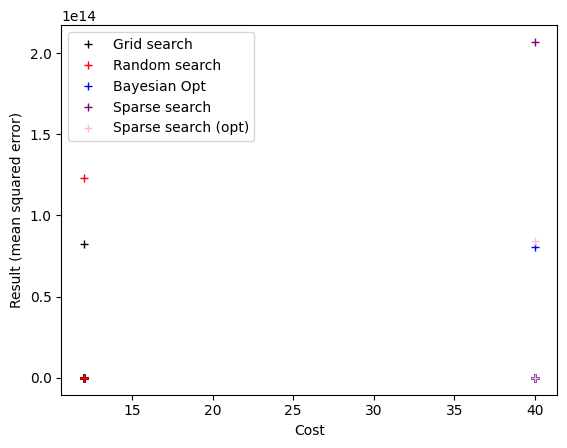

In [6]:
for i in range(len(ids)-1):
    plt.plot(GRID_COST[i], GRID_RESULT[i], '+', color='black')
    plt.plot(RANDOM_COST[i], RANDOM_RESULT[i], '+', color='red')
    plt.plot(BAYESIAN_COST[i], BAYESIAN_RESULT[i], '+', color='blue')
    plt.plot(SPARSE_COST[i], SPARSE_RESULT[i], '+', color='purple')
    plt.plot(SPARSE_COST_OPTIMIZED[i], SPARSE_RESULT_OPTIMIZED[i], '+', color='pink')

plt.xlabel("Cost")
plt.ylabel("Result (mean squared error)")
plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"])
